In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, LeakyReLU, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

In [2]:
# Membaca dataset dari file CSV
dataset = pd.read_csv('nprepros_pond1_linear.csv', parse_dates=["created_at"], index_col="created_at")
dataset.head(10)

,temp,turbidity,oxygen,ph,ammonia,nitrat,length,weight
created_at,,,,,,,,
2021-06-19 00:00:00,24.617541,100.0,4.307053,8.430745,0.458420,0.019258,7.11,2.91
2021-06-19 06:00:00,24.652806,100.0,4.050714,8.401315,0.458420,0.020042,7.11,2.91
2021-06-19 12:00:00,26.271899,100.0,4.166278,8.385208,0.457698,0.020757,7.11,2.91
2021-06-19 18:00:00,26.149711,100.0,3.916278,8.399212,0.458774,0.020690,7.11,2.91
2021-06-20 00:00:00,25.686950,100.0,4.377719,8.405993,0.458420,0.019044,7.50,3.85
2021-06-20 06:00:00,25.407630,100.0,4.208872,8.403096,0.458420,0.018522,7.50,3.85
2021-06-20 12:00:00,26.428867,100.0,3.809421,8.375284,0.458420,0.018027,7.50,3.85
2021-06-20 18:00:00,26.223045,100.0,4.077850,8.391571,0.458420,0.018266,7.50,3.85
2021-06-21 00:00:00,25.634234,100.0,4.110925,8.405592,0.458420,0.017092,7.89,4.79


In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 465 entries, 2021-06-19 00:00:00 to 2021-10-13 00:00:00
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   temp       465 non-null    float64
 1   turbidity  465 non-null    float64
 2   oxygen     465 non-null    float64
 3   ph         465 non-null    float64
 4   ammonia    465 non-null    float64
 5   nitrat     465 non-null    float64
 6   length     465 non-null    float64
 7   weight     465 non-null    float64
dtypes: float64(8)
memory usage: 32.7 KB


In [4]:
dataset.describe()

,temp,turbidity,oxygen,ph,ammonia,nitrat,length,weight
count,465.000000,465.000000,465.000000,465.000000,465.000000,465.000000,465.000000,465.000000
mean,24.913365,97.224609,3.810550,7.095375,0.511774,0.069476,22.016796,118.550645
std,0.724524,8.715656,0.396534,0.581090,0.093297,0.040783,7.531430,98.496454
min,24.000000,50.000000,3.027000,6.068580,0.160603,0.011594,7.110000,2.910000
25%,24.390625,100.000000,3.508719,6.668742,0.458420,0.016728,15.960000,33.730000
50%,24.757738,100.000000,3.782313,7.072797,0.499265,0.089213,22.740000,78.050000
75%,25.229167,100.000000,4.136331,7.476671,0.572759,0.104088,28.573846,191.278461
max,27.680147,100.000000,4.955890,8.430745,0.797010,0.144000,33.450000,318.640000


In [5]:
# Menentukan apakah ada nilai kosong dalam dataset
ada_nilai_kosong = dataset.isnull().values.any()

if ada_nilai_kosong:
    print("Dataset memiliki nilai kosong.")
    
    # Mencari lokasi kosong berdasarkan kolom
    kolom_kosong = dataset.columns[dataset.isnull().any()].tolist()
    print("Kolom yang memiliki nilai kosong:", kolom_kosong)
    
    # Mencari lokasi kosong berdasarkan baris
    baris_kosong = dataset[dataset.isnull().any(axis=1)]
    print("Baris yang memiliki nilai kosong:\n", baris_kosong)
else:
    print("Dataset tidak memiliki nilai kosong.")

Dataset tidak memiliki nilai kosong.


<Axes: xlabel='created_at'>

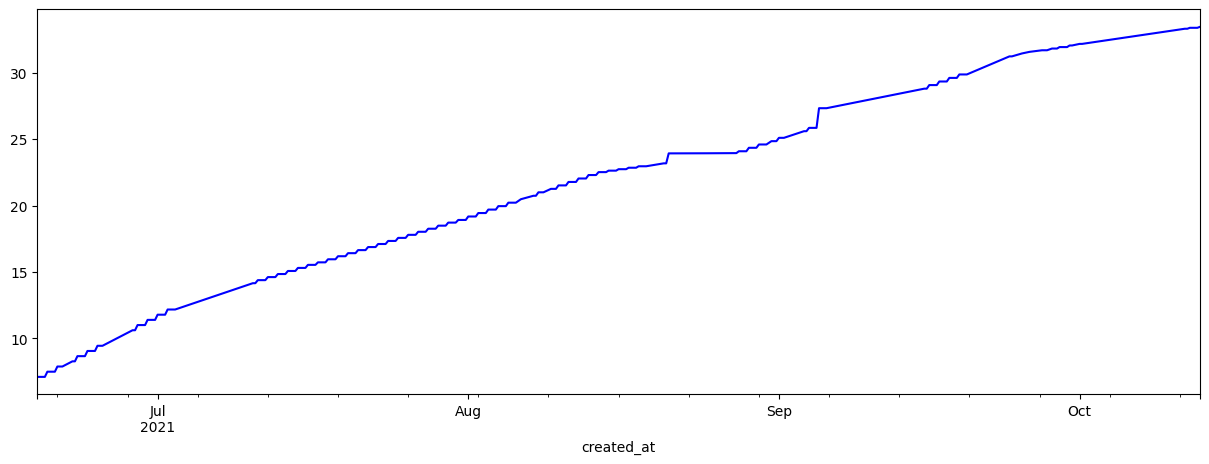

In [6]:
dataset.length.plot(figsize=(15,5), color="b")

<Axes: xlabel='created_at'>

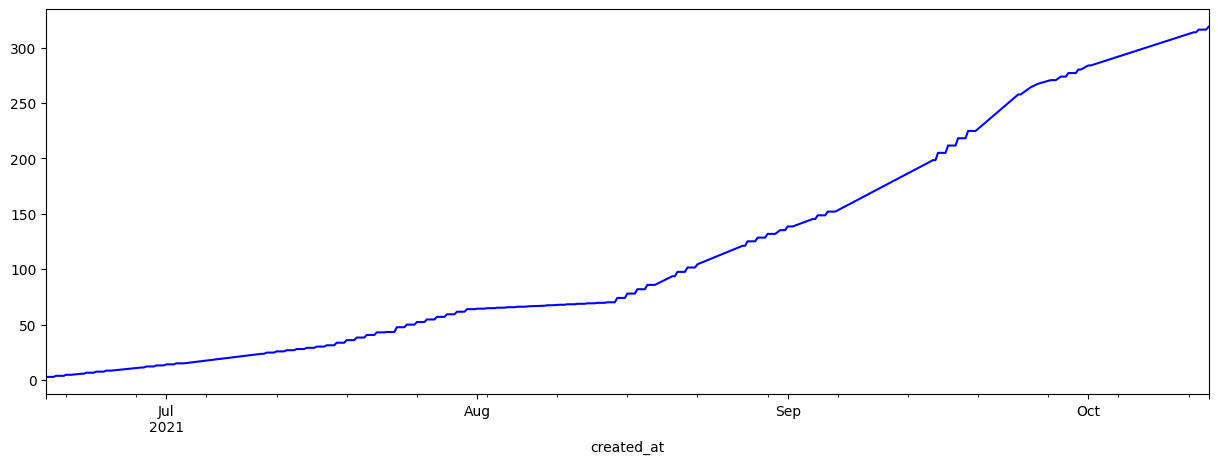

In [7]:
dataset.weight.plot(figsize=(15,5), color="b")

In [8]:
day_dataset = dataset.resample('D', level=0).max()

In [9]:
day_dataset.describe()

,temp,turbidity,oxygen,ph,ammonia,nitrat,length,weight
count,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000
mean,25.146455,97.928717,3.945769,7.100267,0.548647,0.074005,22.120107,120.374570
std,0.706104,7.039450,0.443372,0.591011,0.096779,0.042657,7.587943,100.210021
min,24.036054,53.944444,3.190866,6.068580,0.354900,0.013054,7.110000,2.910000
25%,24.636719,100.000000,3.517422,6.668742,0.472236,0.018184,15.960000,33.730000
50%,25.090278,100.000000,3.921558,7.073983,0.530542,0.096435,22.740000,78.050000
75%,25.422089,100.000000,4.296954,7.488166,0.612260,0.109653,28.686923,194.849231
max,27.680147,100.000000,4.955890,8.430745,0.797010,0.144000,33.450000,318.640000


<Axes: xlabel='created_at'>

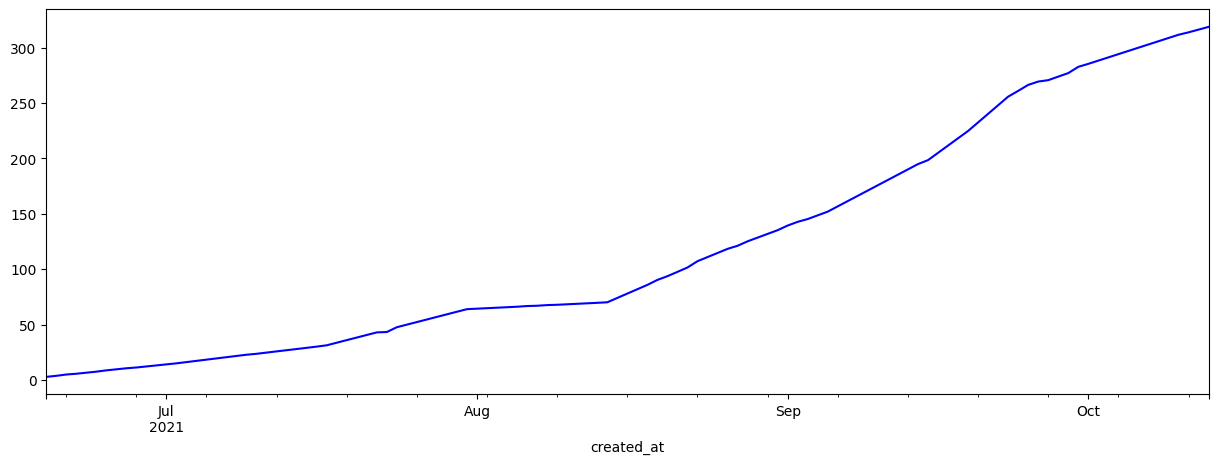

In [10]:
day_dataset.weight.plot(figsize=(15,5), color="b")

In [11]:
# Menghitung pakan harian berdasarkan kolom "length" dan "weight"
# berdasarkan penjelasan jurnal pada dataset 
# Pemberian pakan dilakukan sebanyak 7% dari berat tubuh ikan dalam dua kali pemberian
day_dataset['feed_day'] = (day_dataset['weight']) * 0.07*2

# Menampilkan dataset dengan kolom baru "feed_day"
print(day_dataset)

                 temp  turbidity    oxygen        ph   ammonia    nitrat   
created_at                                                                 
2021-06-19  26.271899      100.0  4.307053  8.430745  0.458774  0.020757  \
2021-06-20  26.428867      100.0  4.377719  8.405993  0.458420  0.019044   
2021-06-21  25.634234      100.0  4.462000  8.405761  0.458420  0.017411   
2021-06-22  25.095409      100.0  4.395750  8.368919  0.458420  0.015512   
2021-06-23  24.745377      100.0  4.307904  8.342940  0.458590  0.015522   
...               ...        ...       ...       ...       ...       ...   
2021-10-09  27.211890      100.0  3.528563  6.123140  0.506527  0.100605   
2021-10-10  27.479466      100.0  3.529956  6.101316  0.510813  0.098596   
2021-10-11  27.680147      100.0  4.110000  6.079492  0.515099  0.104576   
2021-10-12  26.981250      100.0  3.874429  6.068580  0.519386  0.123713   
2021-10-13  26.641447      100.0  4.222000  6.068580  0.519386  0.098700   

           

In [12]:
# Menghitung akumulasi pakan harian (feed_day)
day_dataset['feed_akum'] = day_dataset['feed_day'].cumsum()

# Menampilkan dataset dengan kolom baru "feed_day"
print(day_dataset)

                 temp  turbidity    oxygen        ph   ammonia    nitrat   
created_at                                                                 
2021-06-19  26.271899      100.0  4.307053  8.430745  0.458774  0.020757  \
2021-06-20  26.428867      100.0  4.377719  8.405993  0.458420  0.019044   
2021-06-21  25.634234      100.0  4.462000  8.405761  0.458420  0.017411   
2021-06-22  25.095409      100.0  4.395750  8.368919  0.458420  0.015512   
2021-06-23  24.745377      100.0  4.307904  8.342940  0.458590  0.015522   
...               ...        ...       ...       ...       ...       ...   
2021-10-09  27.211890      100.0  3.528563  6.123140  0.506527  0.100605   
2021-10-10  27.479466      100.0  3.529956  6.101316  0.510813  0.098596   
2021-10-11  27.680147      100.0  4.110000  6.079492  0.515099  0.104576   
2021-10-12  26.981250      100.0  3.874429  6.068580  0.519386  0.123713   
2021-10-13  26.641447      100.0  4.222000  6.068580  0.519386  0.098700   

           

In [13]:
# Create a new column "day" starting from 25
day_dataset['day'] = pd.RangeIndex(start=25, stop=25 + len(day_dataset), step=1)

# Display the dataset with the new "day" column
print(day_dataset)

                 temp  turbidity    oxygen        ph   ammonia    nitrat   
created_at                                                                 
2021-06-19  26.271899      100.0  4.307053  8.430745  0.458774  0.020757  \
2021-06-20  26.428867      100.0  4.377719  8.405993  0.458420  0.019044   
2021-06-21  25.634234      100.0  4.462000  8.405761  0.458420  0.017411   
2021-06-22  25.095409      100.0  4.395750  8.368919  0.458420  0.015512   
2021-06-23  24.745377      100.0  4.307904  8.342940  0.458590  0.015522   
...               ...        ...       ...       ...       ...       ...   
2021-10-09  27.211890      100.0  3.528563  6.123140  0.506527  0.100605   
2021-10-10  27.479466      100.0  3.529956  6.101316  0.510813  0.098596   
2021-10-11  27.680147      100.0  4.110000  6.079492  0.515099  0.104576   
2021-10-12  26.981250      100.0  3.874429  6.068580  0.519386  0.123713   
2021-10-13  26.641447      100.0  4.222000  6.068580  0.519386  0.098700   

           

In [14]:
day_dataset.describe()

,temp,turbidity,oxygen,ph,ammonia,nitrat,length,weight,feed_day,feed_akum,day
count,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000
mean,25.146455,97.928717,3.945769,7.100267,0.548647,0.074005,22.120107,120.374570,16.852440,539.983111,83.000000
std,0.706104,7.039450,0.443372,0.591011,0.096779,0.042657,7.587943,100.210021,14.029403,564.498107,33.919021
min,24.036054,53.944444,3.190866,6.068580,0.354900,0.013054,7.110000,2.910000,0.407400,0.407400,25.000000
25%,24.636719,100.000000,3.517422,6.668742,0.472236,0.018184,15.960000,33.730000,4.722200,72.536935,54.000000
50%,25.090278,100.000000,3.921558,7.073983,0.530542,0.096435,22.740000,78.050000,10.927000,316.590909,83.000000
75%,25.422089,100.000000,4.296954,7.488166,0.612260,0.109653,28.686923,194.849231,27.278892,870.294070,112.000000
max,27.680147,100.000000,4.955890,8.430745,0.797010,0.144000,33.450000,318.640000,44.609600,1971.735464,141.000000


In [15]:
# Menentukan rentang nilai maksimum dan minimum untuk setiap fitur
feature_ranges = {
    'temp': (24, 32),
    'turbidity': (50, 100),
    'oxygen': (3, 5),
    'ph': (6, 9),
    'ammonia': (0, 0.8),
    'nitrat': (0, 5)
}

# Menyalin dataset ke dataframe baru
normalized_dataset = day_dataset.copy()

# Melakukan normalisasi pada fitur-fitur yang perlu dinormalisasi
scaler = MinMaxScaler()
for feature, (min_value, max_value) in feature_ranges.items():
    normalized_values = scaler.fit_transform(normalized_dataset[[feature]])
    normalized_dataset[feature] = normalized_values

# Menampilkan dataset yang telah dinormalisasi
print(normalized_dataset)

                temp  turbidity    oxygen        ph   ammonia    nitrat   
created_at                                                                
2021-06-19  0.613553        1.0  0.632392  1.000000  0.234950  0.058824  \
2021-06-20  0.656628        1.0  0.672429  0.989521  0.234150  0.045740   
2021-06-21  0.438567        1.0  0.720179  0.989423  0.234150  0.033273   
2021-06-22  0.290705        1.0  0.682645  0.973827  0.234150  0.018770   
2021-06-23  0.194650        1.0  0.632874  0.962828  0.234535  0.018844   
...              ...        ...       ...       ...       ...       ...   
2021-10-09  0.871502        1.0  0.191327  0.023098  0.342962  0.668602   
2021-10-10  0.944930        1.0  0.192116  0.013859  0.352657  0.653260   
2021-10-11  1.000000        1.0  0.520749  0.004620  0.362352  0.698927   
2021-10-12  0.808211        1.0  0.387282  0.000000  0.372048  0.845076   
2021-10-13  0.714963        1.0  0.584204  0.000000  0.372048  0.654055   

               length   

In [16]:
normalized_dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 117 entries, 2021-06-19 to 2021-10-13
Freq: D
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   temp       117 non-null    float64
 1   turbidity  117 non-null    float64
 2   oxygen     117 non-null    float64
 3   ph         117 non-null    float64
 4   ammonia    117 non-null    float64
 5   nitrat     117 non-null    float64
 6   length     117 non-null    float64
 7   weight     117 non-null    float64
 8   feed_day   117 non-null    float64
 9   feed_akum  117 non-null    float64
 10  day        117 non-null    int64  
dtypes: float64(10), int64(1)
memory usage: 11.0 KB


In [17]:
normalized_dataset.describe()

,temp,turbidity,oxygen,ph,ammonia,nitrat,length,weight,feed_day,feed_akum,day
count,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000
mean,0.304712,0.955026,0.427701,0.436755,0.438233,0.465463,22.120107,120.374570,16.852440,539.983111,83.000000
std,0.193767,0.152847,0.251199,0.250199,0.218902,0.325764,7.587943,100.210021,14.029403,564.498107,33.919021
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.110000,2.910000,0.407400,0.407400,25.000000
25%,0.164832,1.000000,0.185015,0.254073,0.265399,0.039174,15.960000,33.730000,4.722200,72.536935,54.000000
50%,0.289297,1.000000,0.413984,0.425628,0.397283,0.636760,22.740000,78.050000,10.927000,316.590909,83.000000
75%,0.380351,1.000000,0.626670,0.600968,0.582118,0.737700,28.686923,194.849231,27.278892,870.294070,112.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,33.450000,318.640000,44.609600,1971.735464,141.000000


In [18]:
# Mencoba lebih banyak layer
# Menentukan fitur (X) dan target (y)
features = ['temp', 'turbidity', 'oxygen', 'ph', 'ammonia', 'nitrat', 'weight']
target = ['length', 'feed_akum', 'day']
X_tf = normalized_dataset[features]
y_tf = normalized_dataset[target]

# Membangun model regresi linear dengan beberapa layer tambahan
model_tf = Sequential()
model_tf.add(Dense(128, input_shape=(len(features),), activation='relu'))
model_tf.add(Dense(64, activation='relu'))
model_tf.add(Dense(len(target)))

# Kompilasi model
model_tf.compile(optimizer='adam', loss='mse', metrics=['mae'])

model_tf.summary()

# Melatih model
history = model_tf.fit(X_tf, y_tf, epochs=100, batch_size=4, validation_split=0.1)

# Menampilkan koefisien dan intercept dari model
weights = model_tf.layers[0].get_weights()[0]
biases = model_tf.layers[0].get_weights()[1]
print("Koefisien:", weights)
print("Intercept:", biases)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1024      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 3)                 195       
                                                                 
Total params: 9,475
Trainable params: 9,475
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
27/27 [==============================] - 6s 22ms/step - loss: 95700.2656 - mae: 153.5326 - val_loss: 744974.7500 - val_mae: 552.2626
Epoch 2/100
27/27 [==============================] - 0s 4ms/step - loss: 59382.6172 - mae: 117.3730 - val_loss: 473014.7812 - val_mae: 415.5386
Epoch 3/100
27/27 [==========

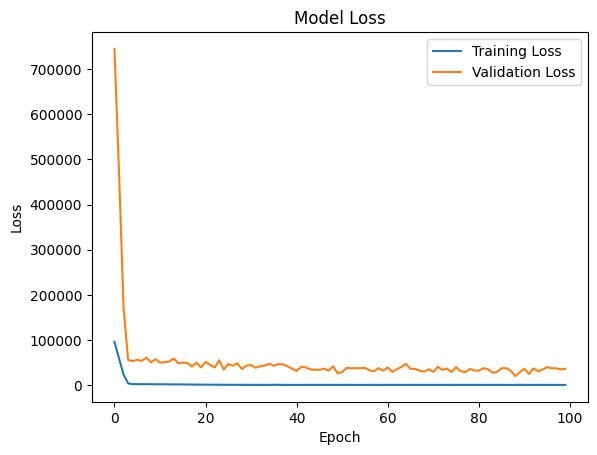

In [19]:
# Plot history epochnya
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [20]:
# Menentukan fitur yang akan digunakan untuk prediksi
new_data = {
    'temp': 27,
    'turbidity': 65,
    'oxygen': 4,
    'ph': 6.6,
    'ammonia': 0.2,
    'nitrat': 2,
    'weight': 100
}

# Menyalin data baru ke dataframe baru
new_data_df = pd.DataFrame([new_data])

# Melakukan normalisasi pada fitur-fitur yang perlu dinormalisasi
for feature, (min_value, max_value) in feature_ranges.items():
    normalized_values = (new_data_df[feature] - min_value) / (max_value - min_value)
    new_data_df[feature] = normalized_values

# Melakukan prediksi menggunakan model regresi linear
predictions = model_tf.predict(new_data_df)

# Menampilkan hasil prediksi
print("Prediksi length, feed_akum, dan day:", predictions)

1/1 [==============================] - 0s 429ms/step
Prediksi length, feed_akum, dan day: [[ 19.55009  414.42618   71.461266]]


In [23]:
# Menyimpan model ke dalam file
model_tf.save('model_regresi.h5')

In [21]:
# Hasil dengan model NN biasa
# iotpond 1
# hasilnya untuk weight 100 
# [[ 19.327662 415.77408   70.610435]]
# [[ 18.756563 410.4815    72.6245  ]]

# iotpond 2
# hasilnya untuk weight 100 
# [[ 18.31957  453.24756   73.135056]]

# iotpond 3
# hasilnya untuk weight 100 
# [[ 18.224924 402.16708   67.430176]]


# Hasil dengan model leaky relu
# iotpond 1
# hasilnya untuk weight 100 
# [[ 18.300047 411.77832   71.16209 ]]

# iotpond 2
# hasilnya untuk weight 100 
# [[ 18.104107 461.60992   67.24234 ]]

# iotpond 3
# hasilnya untuk weight 100 
# [[ 17.372635 395.72516   67.28603 ]]

